In [1]:
import os
import torch
import evaluate
import numpy as np
import pandas as pd
import glob as glob
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

from PIL import Image
from zipfile import ZipFile
from tqdm.notebook import tqdm
from dataclasses import dataclass
from torch.utils.data import Dataset
from urllib.request import urlretrieve

block_plot = False
plt.rcParams['figure.figsize'] = (12, 9)

In [2]:
from transformers import (
    VisionEncoderDecoderModel,
    TrOCRProcessor,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
    default_data_collator
)


In [3]:
bold = f"\033[1m"
reset = f"\033[0m"

In [4]:
def seed_everything(seed_value):
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

In [5]:
class CustomOCRDataset(Dataset):
    def __init__(self, root_dir, df, processor, max_target_length=128):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # The image file name.
        file_name = self.df['file_name'][idx]
        # The text (label).
        text = self.df['text'][idx]
        # Read the image, apply augmentations, and get the transformed pixels.
        image = Image.open(self.root_dir + file_name).convert('RGB')
        image = train_transforms(image)
        pixel_values = self.processor(image, return_tensors='pt').pixel_values
        # Pass the text through the tokenizer and get the labels,
        # i.e. tokenized labels.
        labels = self.processor.tokenizer(
            text,
            padding='max_length',
            max_length=self.max_target_length
        ).input_ids
        # We are using -100 as the padding token.
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]
        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
@dataclass(frozen=True)
class TrainingConfig:
    BATCH_SIZE:    int = 48
    EPOCHS:        int = 35
    LEARNING_RATE: float = 0.00005

@dataclass(frozen=True)
class DatasetConfig:
    DATA_ROOT:     str = 'C:/Users/ATOM/Desktop/ear_tag_data_new'

@dataclass(frozen=True)
class ModelConfig:
    MODEL_NAME: str = 'microsoft/trocr-small-printed'
        

In [7]:
model = VisionEncoderDecoderModel.from_pretrained(ModelConfig.MODEL_NAME)
model.to(device)
#print(model)
# Total parameters and trainable parameters.
#total_params = sum(p.numel() for p in model.parameters())
#print(f"{total_params:,} total parameters.")
#total_trainable_params = sum(
    #p.numel() for p in model.parameters() if p.requires_grad)
#print(f"{total_trainable_params:,} training parameters.")

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-small-printed and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


VisionEncoderDecoderModel(
  (encoder): DeiTModel(
    (embeddings): DeiTEmbeddings(
      (patch_embeddings): DeiTPatchEmbeddings(
        (projection): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): DeiTEncoder(
      (layer): ModuleList(
        (0-11): 12 x DeiTLayer(
          (attention): DeiTAttention(
            (attention): DeiTSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): DeiTSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): DeiTIntermediate(
            (dense): Linear(

In [8]:
processor = TrOCRProcessor.from_pretrained(ModelConfig.MODEL_NAME)
model = VisionEncoderDecoderModel.from_pretrained('seq2seq_model_printed/checkpoint-1890').to(device)


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


In [9]:
# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 10
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

In [10]:
def read_and_show(image_path):
    """
    :param image_path: String, path to the input image.
 
 
    Returns:
        image: PIL Image.
    """
    image = Image.open(image_path).convert('RGB')
    return image

In [11]:
def ocr(image, processor, model):
    """
    :param image: PIL Image.
    :param processor: Huggingface OCR processor.
    :param model: Huggingface OCR model.
 
 
    Returns:
        generated_text: the OCR'd text string.
    """
    # We can directly perform OCR on cropped images.
    pixel_values = processor(image, return_tensors='pt').pixel_values.to(device)
    return_dict = model.generate(pixel_values, output_scores=True, return_dict_in_generate=True)
    generated_ids = model.generate(pixel_values)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    logits = torch.stack(list(return_dict.scores),dim=1)
    import torch.nn.functional as F
    logit_probs = F.softmax(logits, dim=2)
    char_probs = logit_probs.max(dim=2)[0]
    #mask = return_dict.sequences[:,:-1] > 2
    #char_probs[mask] = 1
    cs = torch.min(char_probs.cumprod(dim=1)[:, -1])
    

    

    return generated_text, cs

  1%|▋                                                                                 | 1/120 [00:00<01:33,  1.27it/s]

Name= R258
Confidence_score= 0.3261680603027344
Name= S183
Confidence_score= 0.8818691968917847


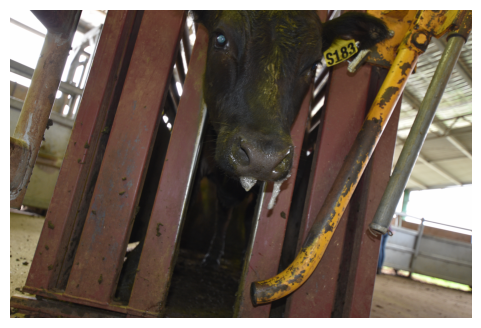

  2%|█▎                                                                                | 2/120 [00:03<03:33,  1.81s/it]

Name= S183
Confidence_score= 0.9519177079200745


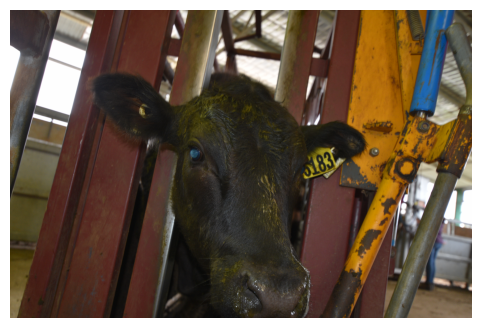

  2%|██                                                                                | 3/120 [00:05<04:06,  2.10s/it]

Name= S183
Confidence_score= 0.8013911843299866


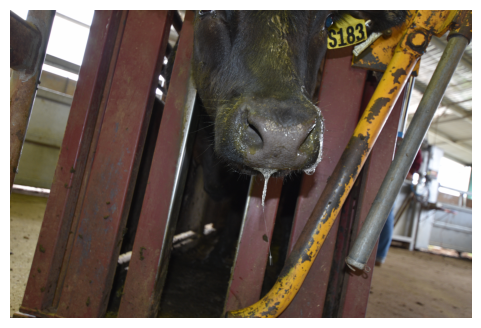

  4%|███▍                                                                              | 5/120 [00:09<03:21,  1.75s/it]

Name= S281
Confidence_score= 0.32131701707839966
Name= R197
Confidence_score= 0.7826041579246521


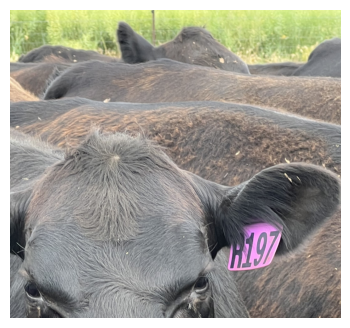

  5%|████                                                                              | 6/120 [00:10<02:51,  1.50s/it]

Name= R197
Confidence_score= 0.8854165077209473


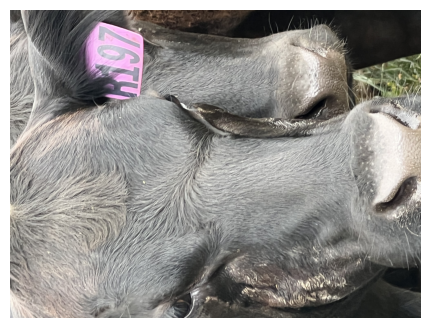

  6%|████▊                                                                             | 7/120 [00:11<02:50,  1.51s/it]

Name= R233
Confidence_score= 0.9735052585601807


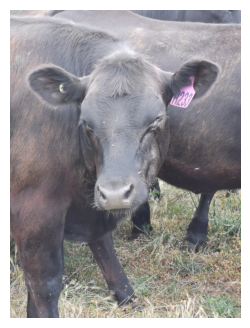

  7%|█████▍                                                                            | 8/120 [00:13<02:43,  1.46s/it]

Name= R233
Confidence_score= 0.7974057793617249


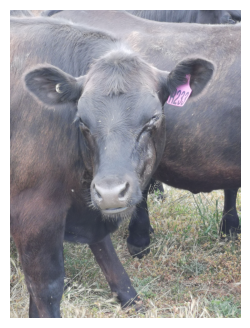

  8%|██████▏                                                                           | 9/120 [00:14<02:38,  1.43s/it]

Name= R233
Confidence_score= 0.7830133438110352


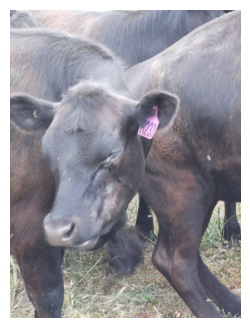

  9%|███████▍                                                                         | 11/120 [00:16<02:08,  1.18s/it]

Name= R233
Confidence_score= 0.556179940700531
Name= R233
Confidence_score= 0.9909037351608276


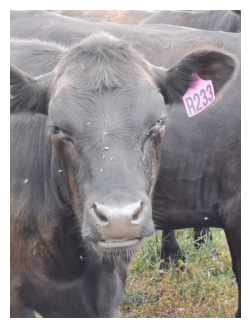

 11%|████████▊                                                                        | 13/120 [00:18<01:55,  1.08s/it]

Name= R233
Confidence_score= 0.5618904232978821
Name= R233
Confidence_score= 0.9597856998443604


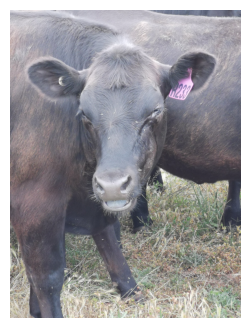

 12%|█████████▍                                                                       | 14/120 [00:19<02:04,  1.17s/it]

Name= R233
Confidence_score= 0.7974057793617249


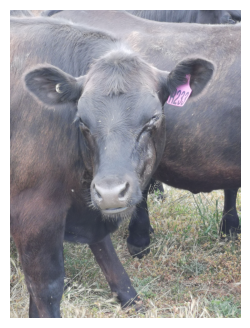

 12%|██████████▏                                                                      | 15/120 [00:21<02:07,  1.22s/it]

Name= R233
Confidence_score= 0.7830133438110352


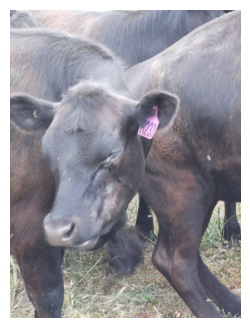

 14%|███████████▍                                                                     | 17/120 [00:23<01:53,  1.10s/it]

Name= R233
Confidence_score= 0.556179940700531
Name= R233
Confidence_score= 0.9909037351608276


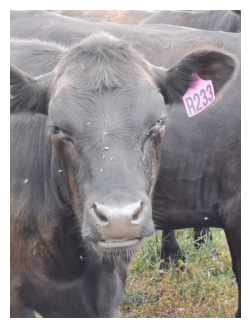

 16%|████████████▊                                                                    | 19/120 [00:25<01:45,  1.05s/it]

Name= R233
Confidence_score= 0.5618904232978821
Name= R233
Confidence_score= 0.9735052585601807


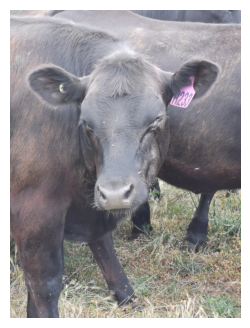

 17%|█████████████▌                                                                   | 20/120 [00:26<01:54,  1.15s/it]

Name= R233
Confidence_score= 0.9597856998443604


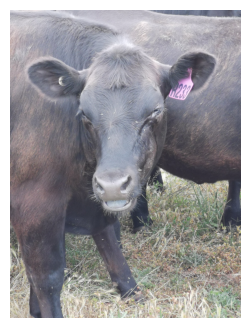

 18%|██████████████▏                                                                  | 21/120 [00:28<01:59,  1.21s/it]

Name= R258
Confidence_score= 0.7563244104385376


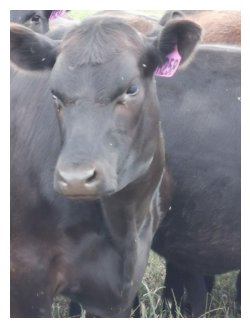

 18%|██████████████▊                                                                  | 22/120 [00:29<02:12,  1.35s/it]


KeyboardInterrupt: 

In [12]:
import os
import glob
import shutil
from tqdm import tqdm
import matplotlib.pyplot as plt

def eval_new_data(
    data_path='C:/Users/ATOM/Desktop/CSUNikkon/*',
    num_samples=150,
    threshold=0.6
):
    new_directory = 'C:/Users/ATOM/Desktop/CSUNikkon_ear_tags_new'
    if not os.path.exists(new_directory):
        os.makedirs(new_directory)

    image_paths = glob.glob(data_path)
    for i, image_path in tqdm(enumerate(image_paths), total=len(image_paths)):
        if i == num_samples:
            break
        image = read_and_show(image_path)
        text = ocr(image, processor, model)

        name = text[0]
        confidence_score = text[1].item()

        print('Name=', name)
        print('Confidence_score=', confidence_score)

        if confidence_score >= threshold:
            folder_path = os.path.join(new_directory, name)
            if not os.path.exists(folder_path):
                os.makedirs(folder_path)
            shutil.copy(image_path, folder_path)

            plt.figure(figsize=(7, 4))
            plt.imshow(image)
            plt.axis('off')
            plt.show()


eval_new_data(num_samples=150)
